<a href="https://colab.research.google.com/github/Auckland68/Projects/blob/main/Dbpedia_Dataset_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Import libraries and dataset

In [ ]:
!pip install pyldavis
!pip install -U gensim

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import pyLDAvis
import pyLDAvis.sklearn

# Modelling and feature engineering
import sklearn.decomposition
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import gensim

# Text processing
import nltk

In [ ]:
from google.colab import drive
drive.mount('MyDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at MyDrive


# 2.0 Preprocessing

In [ ]:
# Read in datasets
data = pd.read_csv('/content/MyDrive/My Drive/dbpediatrain.csv',names = ["label","title","text"])
data_test = pd.read_csv('/content/MyDrive/My Drive/dbpediatest.csv',names = ["label","title","text"])

In [ ]:
# Take a sample of the larger dataset to work with as training set.
data = data.sample(8000, random_state = 0)

# Take a sample of the original test set to use to predict 
test_data = data_test.sample(2000, random_state = 42)
test_data.reset_index(inplace = True, drop = True)


# 3.0 Examining the Dataset

In [ ]:
# Are there any null entries and what are the features?
data.shape

(8000, 3)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 245601 to 476345
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8000 non-null   int64 
 1   title   8000 non-null   object
 2   text    8000 non-null   object
dtypes: int64(1), object(2)
memory usage: 250.0+ KB


In [ ]:
# Examine sample of data
data.sample(5)

,label,title,text
318185,8,Silver Snag Lake,Silver Snag Lake is a lake on Vancouver Islan...
530777,14,Sămănătorul,Sămănătorul or Semănătorul (pronounced [səmən...
500062,13,Tess of the d'Urbervilles (1924 film),Tess of the d'Urbervilles was a 1924 American...
92092,3,Suede (singer),Suede is an American pop cabaret and jazz sin...
411958,11,Sanicula tracyi,Sanicula tracyi is a species of flowering pla...


In [ ]:
# Look at one document
data.text.iloc[300]

' Freeworld Entertainment was a record label formed in 1997 by Dallas Austin and Kevin Czinger.'

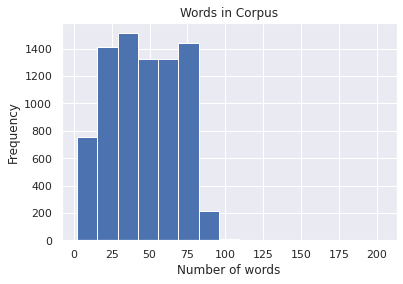

In [ ]:
# Number of words in document
def doc_word(text):
  doc_word = round(text.str.split().apply(len),2)
  return doc_word

length_doc = doc_word(data.text)

# Histogram of length of each document
plt.hist(length_doc,bins = 15)
plt.title("Words in Corpus")
plt.xlabel("Number of words")
ax = plt.ylabel("Frequency")

In [ ]:
print("Maximum length:",length_doc.max())
print("Minimum_length:",length_doc.min())
print("Average_length:",round(length_doc.mean(),2))

Maximum length: 203
Minimum_length: 2
Average_length: 46.09


In [ ]:
# Look for outliers
sort_doc = length_doc.sort_values(ascending = False)
sort_doc[0:13]

270940    203
54812     172
9658      148
552696    118
207675    118
380810    114
108194    107
110176    107
61739     106
58962     106
146207    100
535959    100
498466     98
Name: text, dtype: int64

Analysis:

*   The average length of document is 46 words within a range of 2 to 203
*   There are 12 documents over 100 words and one over 200.
*   Apart from the few outliers, the rest of the data seems roughly normally distributed.



# 4.0 Creating the Document Term Matrix

The LDA model takes in a bag-of-words based on word counts rather than a weighted td-idf as noted Blei notes that the model does not require weights. Various parameters can be set within the CountVectorizer to tweak the words that are included.

## 4.1 Bag of Words with single words (unigrams)

In [ ]:
# Tokensize, lower case, remove accents and stopwords. Max_df - ignores words found in more than 
# 95% documents and min_df ignores those in less than 5 documents. Only unigrams included.

vectorizer = CountVectorizer(strip_accents="ascii",max_df = 0.95,min_df = 5,stop_words='english')

In [ ]:
# The vectorized dataset is created by running fit an transform on the count_vectorizer object.
# The bag of words has documents as rows and unique words as columns.
vec = vectorizer.fit_transform(data.text)
print(vec.shape)

(8000, 5528)


In [ ]:
# The bag of words or document term matrix is a sparse matrix.
print(type(vec))
#Percentage of cells with non-zero values
data_dense = vec.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

<class 'scipy.sparse.csr.csr_matrix'>
Sparsicity:  0.3339114507959479 %


Two thirds of the matrix is zero.

In [ ]:
# Extract words from the data vector
feature_names = vectorizer.get_feature_names()
len(feature_names)

5528

In [ ]:
# Find top words in bag of words with frequencies
all_words = vec.sum(axis=0)
freq_word = [(word, all_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
freq_word =sorted(freq_word, key = lambda x: x[1], reverse=True)
top_ten_freq = freq_word[0:11]
top_ten_freq

[('school', 1450),
 ('born', 1241),
 ('film', 1166),
 ('district', 1066),
 ('album', 1005),
 ('known', 981),
 ('species', 936),
 ('family', 875),
 ('located', 867),
 ('county', 866),
 ('american', 828)]

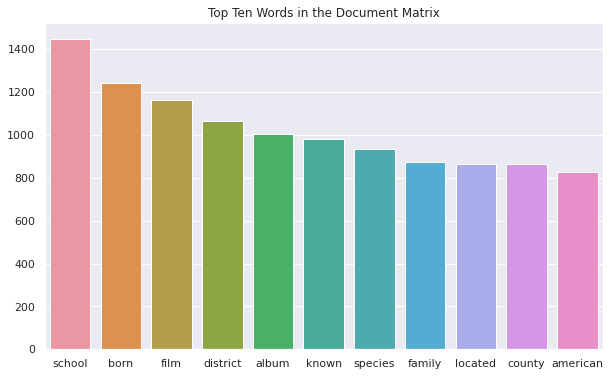

In [ ]:
# Extract and plot top words
word_name = []
word_count = []
for word in top_ten_freq:
  w = word[0]
  c = word[1]
  word_name.append(w)
  word_count.append(c)

plt.figure(figsize = (10,6)) 
plt.title("Top Ten Words in the Document Matrix")
ax = sns.barplot(x=word_name,y=word_count)

In [ ]:
# Examine a slice from the dtm
feature_names[2500:2510]

['herb',
 'herbaceous',
 'herbert',
 'herbs',
 'heritage',
 'herman',
 'hermann',
 'hero',
 'herzegovina',
 'hesperiidae']

## 4.2 Bigrams

In [ ]:
# Find the top bigrams - words that occur together

def bigram(text,n):
    vectorizer_2 = CountVectorizer(strip_accents="ascii",ngram_range = (n,n), 
                            max_df = 0.95,min_df = 5,stop_words='english')
    vec_ngram = vectorizer_2.fit_transform(text)
    vec_sum = vec_ngram.sum(axis=0) 
    freq_ngram = [(word, vec_sum[0, idx]) 
                  for word, idx in vectorizer_2.vocabulary_.items()]
    freq_ngram_sorted =sorted(freq_ngram, key = lambda x: x[1], reverse=True)
    return freq_ngram_sorted[:10]

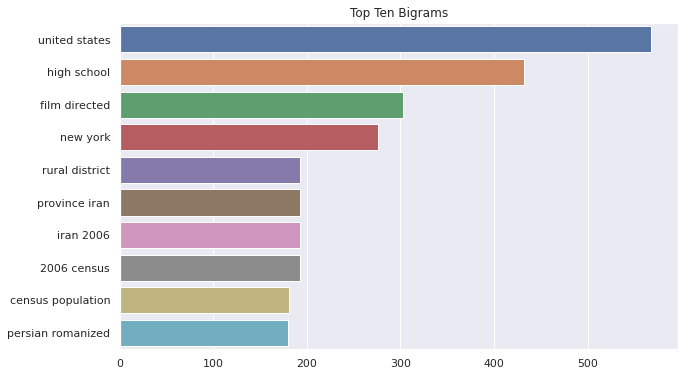

In [ ]:
top_bigrams = bigram(data["text"],2)
x,y=map(list,zip(*top_bigrams))
plt.figure(figsize = (10,6))
plt.title("Top Ten Bigrams")
ax = sns.barplot(x=y,y=x)

Analysis:
*   The top unigrams show the word 'school' occurs across many of the documents and it is likely that it will be shared across topics.
*   United States is the most frequent bigram occurring in more than 500 documents so this should be borne in mind when analysing the output of the model, if these two words occur together in word frequency.



# 5.0 Fitting the Base LDA model

In [ ]:
# Topics set to 14 as per dataset, in practice usually unknown and estimated.
# Doc_topic and word_topic priors (alpha and beta) are doc-topic and word-topic 
# densities. Learning method Online Variational Bayes and iterations to 15 as 
# dataset is large. All other defaults accepted.

topics = 14
iterations = 15
method = "online"
lda_model = LatentDirichletAllocation(n_components = topics, 
                                      max_iter = iterations,random_state = 42, 
                                      learning_method = method)

In [ ]:
# Fit the model and transform
lda = lda_model.fit(vec)
lda_base = lda.transform(vec)

In [ ]:
# Perplexity is defined as exp(-1. * log-likelihood per word)  - the lower the
# better. How 'perplexed' is the model with the words presented.
base_perplex = lda.perplexity(vec)
print("Base model perplexity:",base_perplex)

Base model perplexity: 1831.0481140174247


In [ ]:
# Log likelihood - the higher the better. Difficult to judge as just based on 
# training data
base_log = lda.score(vec)
print("Base model log likelihood:", base_log)

Base model log likelihood: -1278404.061221314


# 6.0 Examining the Output

## 6.1 Document Topic Distribution

In [ ]:
# Document-topic matrix shape confirmed to be as expected with documents as 
# rows and topics as columns
dtm = lda_base
dtm.shape

(8000, 14)

In [ ]:
# Example topic shows array of probabilities for a sample document over 14 topics
dtm[10]

array([0.00324676, 0.0032468 , 0.00324675, 0.05189128, 0.51730476,
       0.2924415 , 0.00324675, 0.00324679, 0.00324675, 0.00324679,
       0.04941508, 0.00324675, 0.05972648, 0.00324676])

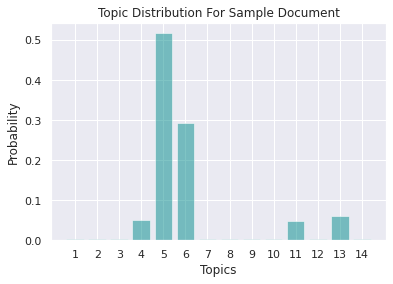

In [ ]:
# Plot on a graph to confirm
topics = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
probs = list(dtm[10])
plt.bar(topics, probs, align='center', alpha=0.5, color = "darkcyan")
plt.xticks(topics)
plt.ylabel('Probability')
plt.xlabel("Topics")
ax = plt.title('Topic Distribution For Sample Document')

In [ ]:
# Create dataframe showing topic-document distributions totalling to one and dominant topics listed
df_dtm = pd.DataFrame(data=dtm, columns=topics)

# Add columns for top topic and the total sum of probabilities for each document over the topics.
df_dtm["Topic"] = df_dtm.idxmax(axis = 1)
df_dtm["Prob"] = df_dtm.iloc[:,0:14].sum(axis=1)
df_dtm.shape

(8000, 16)

In [ ]:
df_dtm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Topic,Prob
0,0.002041,0.002041,0.187793,0.002041,0.335662,0.002041,0.002041,0.115238,0.002041,0.002041,0.002041,0.002041,0.340899,0.002041,13,1.0
1,0.003106,0.003106,0.003106,0.095146,0.003106,0.003106,0.003106,0.266455,0.003106,0.512441,0.003106,0.003106,0.094901,0.003106,10,1.0
2,0.066457,0.415241,0.223984,0.004202,0.004202,0.004202,0.004202,0.004202,0.004202,0.004202,0.252301,0.004202,0.004202,0.004202,2,1.0
3,0.056391,0.003759,0.003759,0.003759,0.003759,0.537157,0.003759,0.056391,0.132595,0.075076,0.003759,0.003759,0.003759,0.112315,6,1.0
4,0.004202,0.004202,0.004202,0.004202,0.004202,0.743568,0.004202,0.004202,0.004202,0.206012,0.004202,0.004202,0.004202,0.004202,6,1.0


In [ ]:
df_dtm.shape

(8000, 16)

In [ ]:
# Obtain value counts per topic - note: we don't know what the topics are at this point
x = pd.DataFrame(df_dtm["Topic"].value_counts())
x.T

,5,4,13,6,9,10,3,2,1,7,11,8,12,14
Topic,1098,1032,951,864,785,613,610,475,411,382,246,230,218,85


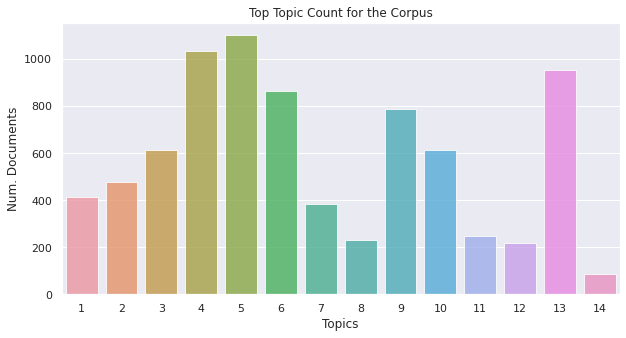

In [ ]:
# Plot top topic for all documents
plt.figure(figsize=(10,5))
sns.barplot(x.index, x.Topic, alpha=0.8)
plt.title("Top Topic Count for the Corpus")
plt.ylabel("Num. Documents")
ax = plt.xlabel("Topics")

## 6.2 Word Topic Distributions

In [ ]:
# Word-topic distributions matrix has 14 topics as rows and number of unique words as columns
wtm = lda_model.components_
wtm.shape

(14, 5528)

In [ ]:
# Examine example topic with word weights across all words.
wtm[11]

array([0.07142862, 0.07142889, 0.0714318 , ..., 5.78420382, 0.07142892,
       0.07142857])

In [ ]:
# Sum of all word weights
wtm[11].sum()

8527.603449001777

In [ ]:
# Transform weights to probabilities that sum to one not done automatically in Scikit Learn
wtm/=wtm.sum(axis = 1)[:,np.newaxis]

In [ ]:
# Extract top words index positions for a sample topic based on weights
example = wtm[11]
top_words_example = example.argsort()[-14:]
top_words_example

array([ 458, 2886, 3031,  626, 3914, 1748, 1479, 5413, 5330, 4734, 3557,
       1837, 2897, 3311])

In [ ]:
# Reference index positions back to feature names
for i in top_words_example:
  print(vectorizer.get_feature_names()[i])

administrative
kilometres
lies
approximately
poland
district
county
west
village
south
north
east
km
mi


This topic seems to be about villages

In [ ]:
# Function to print out top words (code from Scikit learn documentation)

n_top_words = 10

def top_words(lda_model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
# Run function
tf_feature_names = vectorizer.get_feature_names()
top_words(lda_model, tf_feature_names, n_top_words)

Topic #0: family species plant america india endemic moth indian habitat tropical
Topic #1: book published novel series story written fiction short magazine japanese
Topic #2: river class navy war united states world ship built ii
Topic #3: species genus family lake known south mountain native long common
Topic #4: film company directed based american starring science journal italian founded
Topic #5: born played football league professional player april october currently american
Topic #6: district village province 2006 population county census rural iran persian
Topic #7: church st building style century york john parish non england
Topic #8: album released music band studio records singer rock label american
Topic #9: member politician new served born york american house party state
Topic #10: built french aircraft designed services car single produced light corporation
Topic #11: mi km east north south village west county district poland
Topic #12: school located high university co

In [ ]:
# Dataframe to show word-topic probability distributions for each word over 
# every topic with total probabilities summing to one
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5","Topic6","Topic7","Topic8","Topic9","Topic10",
       "Topic11","Topic12","Topic13","Topic14"]
df_word_prob = pd.DataFrame(wtm, columns = [vectorizer.get_feature_names()], index = ind)
df_word_prob["Prob"] = df_word_prob.iloc[:,:].sum(axis=1)
df_word_prob.head()

,00,01,08,10,100,1000,10000,101,102,103,104,105,108,10th,11,110,11000,112,113,114,116,118,11th,12,120,1200,122,125,126,127,128,12th,13,130,13th,14,140,1400,14th,15,...,wright,write,writer,writers,writes,writing,writings,written,wrote,wurttemberg,wyoming,xbox,ya,yacht,yale,yankees,yard,yazd,ye,year,years,yellow,yellowish,yemen,york,yorkshire,young,younger,youngest,youth,yugoslavia,yukon,yunnan,zagreb,zealand,zero,zielona,zone,zoo,Prob
Topic1,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000276,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.001040,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000517,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.001066,0.000640,0.000008,0.000008,0.000008,0.000008,0.000008,1.0
Topic2,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000513,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.002012,0.000512,0.014413,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.005171,0.000006,0.000006,0.000006,0.000006,0.000006,0.009408,0.000006,0.000006,0.000159,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,1.0
Topic3,0.000006,0.000006,0.000006,0.000896,0.001412,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000478,0.000006,0.000006,0.000504,0.000006,0.000006,0.000006,0.000305,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000482,0.000006,0.000385,0.000006,0.000006,0.002272,0.000700,0.000006,0.001570,0.000453,0.000416,0.000006,0.001218,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000814,0.000006,0.000006,0.002046,0.000006,0.000006,0.000006,0.000179,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000543,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,1.0
Topic4,0.000004,0.000004,0.000004,0.001846,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000374,0.000004,0.000004,0.000004,0.000004,0.000282,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000965,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000674,0.001878,0.000257,0.000425,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.001236,0.000004,1.0
Topic5,0.000413,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000255,0.000004,0.000004,0.000004,0.000004,0.000004,0.006214,0.001569,0.000004,0.000004,0.000359,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.003401,0.000008,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004

In [ ]:
# Looking at a sample of words with probabilities
df_word_prob.iloc[:,2500:2510].head()

,herb,herbaceous,herbert,herbs,heritage,herman,hermann,hero,herzegovina,hesperiidae
Topic1,0.000008,0.001660,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
Topic2,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
Topic3,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000709,0.000006,0.000006
Topic4,0.002395,0.000004,0.000004,0.000361,0.000004,0.000004,0.000004,0.000004,0.000004,0.000508
Topic5,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


In [ ]:
# Create word topic matrix dataframe

# Sort top ten words by weight and then use to look up words
all_words = np.array(feature_names)
topic_top = []
for topic_weights in wtm:
  top_word_ind = (-topic_weights).argsort()[:10]
  topic_top.append(all_words.take(top_word_ind))
    
# Create topic - keywords Dataframe
cols = ["Word1","Word2","Word3","Word4","Word5","Word6","Word7","Word8","Word9","Word10"]
ind = ["Topic1","Topic2","Topic3","Topic4","Topic5","Topic6","Topic7","Topic8","Topic9","Topic10",
       "Topic11","Topic12","Topic13","Topic14"]

topic_word_matrix = pd.DataFrame(topic_top,columns = cols ,index = ind)                                  
topic_word_matrix


,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10
Topic1,family,species,plant,america,india,endemic,moth,indian,habitat,tropical
Topic2,book,published,novel,series,story,written,fiction,short,magazine,japanese
Topic3,river,class,navy,war,united,states,world,ship,built,ii
Topic4,species,genus,family,lake,known,south,mountain,native,long,common
Topic5,film,company,directed,based,american,starring,science,journal,italian,founded
Topic6,born,played,football,league,professional,player,april,october,currently,american
Topic7,district,village,province,2006,population,county,census,rural,iran,persian
Topic8,church,st,building,style,century,york,john,parish,non,england
Topic9,album,released,music,band,studio,records,singer,rock,label,american
Topic10,member,politician,new,served,born,york,american,house,party,state


In [ ]:
# Try to infer the topics based on original dataset - some are very fuzzy!!
Inferred = ["Plant","Written","Transport","Animal", "Film",
            "Athlete","Village","Building","Album","Office Holder",
            "Company","Natural","Education","Artist"]
            
                       
topic_word_matrix["Inferred Topic"] = Inferred
topic_word_matrix

,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Inferred Topic
Topic1,family,species,plant,america,india,endemic,moth,indian,habitat,tropical,Plant
Topic2,book,published,novel,series,story,written,fiction,short,magazine,japanese,Written
Topic3,river,class,navy,war,united,states,world,ship,built,ii,Transport
Topic4,species,genus,family,lake,known,south,mountain,native,long,common,Animal
Topic5,film,company,directed,based,american,starring,science,journal,italian,founded,Film
Topic6,born,played,football,league,professional,player,april,october,currently,american,Athlete
Topic7,district,village,province,2006,population,county,census,rural,iran,persian,Village
Topic8,church,st,building,style,century,york,john,parish,non,england,Building
Topic9,album,released,music,band,studio,records,singer,rock,label,american,Album
Topic10,member,politician,new,served,born,york,american,house,party,state,Office Holder


The model has identified most of the topics but there is still some fuzziness with words occurring over different topics.

# 7.0 Visualising the Model 

## a) Using Dimensionality Reduction

In [ ]:
# Document term matrix shape
dtm.shape

(8000, 14)

In [ ]:
# Reduce dimensionality of data to view on a graph using t-stochastic neighbor embedding (TSNE) 
tsne = TSNE(n_components = 2, init = 'pca', random_state = 42)

In [ ]:
lda_tsne = tsne.fit_transform(dtm)

In [ ]:
# Document term matrix reduced to 2 dimensions
df_tsne = pd.DataFrame(lda_tsne)
df_tsne.shape

(8000, 2)

In [ ]:
df_tsne.head()

,0,1
0,-37.245071,43.431168
1,4.551156,-11.532793
2,-15.686502,4.287633
3,-47.015785,-34.667137
4,-58.803867,-38.559959


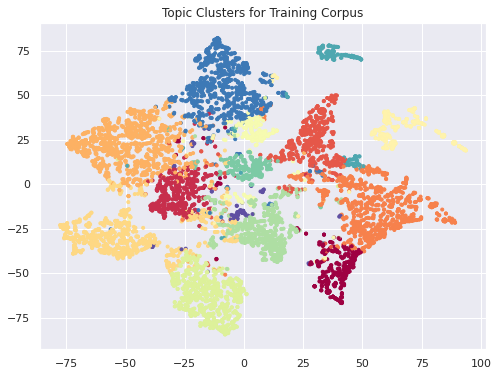

In [ ]:
plt.subplots(figsize = (8,6))
plt.scatter(df_tsne[0],df_tsne[1],c = df_dtm["Topic"],cmap = plt.cm.Spectral,s=9) 
ax = plt.title("Topic Clusters for Training Corpus")

The data is in clusters but there is some overlap with topics which reflects the fuzziness of the word-topic matrix.

## b) Using PYLdaVis - Interactive Visualisation

In [ ]:
# Create the interactive visualisation
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda_model,vec,vectorizer,mds = "tsne")
p                          

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4        1.425140 -203.131439       1        1  11.502053
12      93.696953  -55.018154       2        1  11.162348
5      141.694016   25.320429       3        1  10.706281
3     -126.233505    5.739788       4        1   9.283297
9      -59.868134  101.519302       5        1   8.967741
8      151.966629  133.119141       6        1   8.298983
2       12.542690 -101.441658       7        1   7.131850
1       49.372585   57.773476       8        1   6.682855
7      203.505997  -84.541840       9        1   5.132742
11     119.923477 -166.068970      10        1   4.861295
0      -19.315592   -8.882428      11        1   4.831298
10     -95.841057 -109.373474      12        1   4.437846
6       37.554749  165.057098      13        1   3.902539
13     243.648911   32.733547      14        1   3.098873, topic_info=           Term         Freq        Total Category  logprob  loglift
4489     school  1413.000000  1413.000000  Default  30.0000  30.0000
2130       film  1126.000000  1126.000000  Default  29.0000  29.0000
525       album   972.000000   972.000000  Default  28.0000  28.0000
1748   district  1040.000000  1040.000000  Default  27.0000  27.0000
912        born  1208.000000  1208.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
719   australia    61.893826   185.905209  Topic14  -4.4450   2.3743
2643  including    63.646588   221.347112  Topic14  -4.4171   2.2277
3514        new    95.036066   800.891417  Topic14  -4.0161   1.3427
32           13    43.415692   144.302066  Topic14  -4.7996   2.2730
3342   minister    40.902248   119.849649  Topic14  -4.8592   2.3991

[718 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5        12  0.962757     1000
14        2  0.157811       11
14        3  0.444210       11
14        5  0.105208       11
14       10  0.280553       11
...     ...       ...      ...
5507     13  0.979122       ye
5513      5  0.695320     york
5513      9  0.302912     york
5515      8  0.991790    young
5523     14  0.985177  zealand

[1019 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 13, 6, 4, 10, 9, 3, 2, 8, 12, 1, 11, 7, 14])

A good model will have clearly defined large circles and not clustered together. If the model has too many topics there will be a lot of overlaps as the topics have many words in common and the distance between circles show how different the topics are from each other.

> Indented block



*   On the right panel - choose a word and it will show which topics are associated with the word e.g. 'river' is associated with one topic, so the other circles will disappear.
*   On the left panel - the relative size of a circle indicates where most of the occurrences of a particular word appears.
*   Choose a topic and the chart will show how often each term occurs in that topic in red


# 8.0 Model Performance and Hyperparameter Tuning


Scikit Learn LDA models can be compared using Perplexity and Log likelihood with higher log likelihood and lower the perplexity scores better. The effect of changing some of the parameters is examined here but is not exhaustive due to project length constraints.

## 8.1 Using Grid Search to Find Optimal Model

Grid Search was attempted (code below) to find optimal parameters for topics and learning decay, which are two of the most important parameters in the model.  This was computationally extremely demanding so randomized grid search was used initially and then each of the parameters were investigated separately.

In [ ]:
# set up parameters, and run the grid search on the model
#search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}
#lda = LatentDirichletAllocation(learning_method = 'online')
#model = GridSearchCV(lda, param_grid=search_params)
#model.fit(vec)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9], 'doc_topic_prior':[0.1,0.5,1.0],'topic_word_prior':[0.1,0.5,1.0]}
lda = LatentDirichletAllocation(learning_method = 'online')
model = RandomizedSearchCV(lda, param_distributions = search_params, random_state=0)

In [ ]:
model.fit(vec)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LatentDirichletAllocation(batch_size=128,
                                                       doc_topic_prior=None,
                                                       evaluate_every=-1,
                                                       learning_decay=0.7,
                                                       learning_method='online',
                                                       learning_offset=10.0,
                                                       max_doc_update_iter=100,
                                                       max_iter=10,
                                                       mean_change_tol=0.001,
                                                       n_components=10,
                                                       n_jobs=None,
                                                       perp_tol=0.1,
                                                       random_sta

In [ ]:
model.best_params_

{'doc_topic_prior': 0.5,
 'learning_decay': 0.5,
 'n_components': 5,
 'topic_word_prior': 0.1}

In [ ]:
# Trying these parameters in the model and using to derive perplexity
lda_grid = LatentDirichletAllocation(n_components = 5,doc_topic_prior = 0.5,topic_word_prior = 0.1,learning_method="online",
                                     max_iter = 15,learning_decay = 0.5)
model_grid = lda_grid.fit(vec)
model_grid.perplexity(vec)

1858.8494615208285

Analysis:
This model returns a slightly higher perlexity than the base model.

## 8.2 Find the Optimum Number of Topics 

In [ ]:
# Function to obtain perplexity and likelihood for different numbers of topics
def scoring(topic):

  lda2_model = LatentDirichletAllocation(n_components = topic, 
                                         max_iter = 15,random_state = 42, 
                                         learning_method = 'online')
  lda2 = lda2_model.fit(vec)
  perplex2 = lda2_model.perplexity(vec)
  like2 = lda2_model.score(vec)

  return perplex2,like2

In [ ]:
# Try a range of values into the function
topic_num = []
perplexity = []
log_score = []
for i in range(1,21):
  topic_num.append(i)
  result = scoring(i)
  perplexity.append(result[0])
  log_score.append(result[1])

In [ ]:
test = pd.DataFrame([topic_num,perplexity,log_score]).T
test.columns = (["Topics","Perplexity","Log"])
test.head()

,Topics,Perplexity,Log
0,1.0,2401.690429,-1.324568e+06
1,2.0,2012.251910,-1.294462e+06
2,3.0,1917.937502,-1.286293e+06
3,4.0,1863.884691,-1.281429e+06
4,5.0,1817.681225,-1.277157e+06
5,6.0,1803.556765,-1.275830e+06
6,7.0,1843.268580,-1.279536e+06
7,8.0,1865.943240,-1.281616e+06
8,9.0,1838.900425,-1.279132e+06
9,10.0,1899.925273,-1.284688e+06


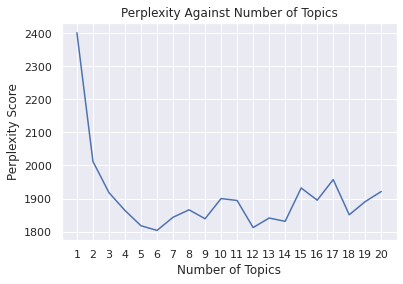

In [ ]:
# Plot perplexity against number of topics
plt.plot(topic_num,perplexity)
plt.title("Perplexity Against Number of Topics")
plt.xlabel("Number of Topics")
plt.xticks(topic_num)
ax = plt.ylabel("Perplexity Score")


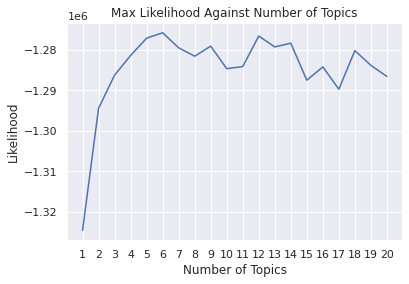

In [ ]:
# Plot likelihood against number of topics
plt.plot(topic_num,log_score)
plt.title("Max Likelihood Against Number of Topics")
plt.xlabel("Number of Topics")
plt.xticks(topic_num)
ax = plt.ylabel("Likelihood")

### What happens at much higher numbers of topics?

In [ ]:
# Set to 30,50 and 100 topics
r1 = scoring(30)
r2 = scoring(50)
r3 = scoring(100)
print("30 topics:",r1)
print("50 topics:",r2)
print("100 topics:",r3)

30 topics: (1984.492974283586, -1292098.2352548614)
50 topics: (2278.6569664205913, -1315619.1887880042)
100 topics: (2994.631962490516, -1362114.7895291573)


Analysis:

*   Perplexity falls and log-likelihood increases sharply up to 5 topics.
*   The lowest perplexity and highest log-likelihood is at 6 topics. This could be because several topic categories share words. The Word-Topic matrix clearly illustrates this as it struggles to separate some of the words into distinct topics and the TSNE graph shows several clusters overlapping. Interestingly, perplexity and likelihood dip and peak respectively at 12 topics as granularity in the data increases.
*   Above 12 topics perplexity seems to oscillate and running this model with 30,50 and 100 topics it tends to increase.
*   The 14 topic model is retained in order to be able to compare results with the original dataset, since 6 topics would clearly not capture the different topics in the data.









## 8.3 Varying Learning Decay

The Learning decay controls the learning rate in the online learning method which determines the step size at each iteration as the model converges to the minimum.

In [ ]:
# Learning Decay varies the learning rate over time. 
# Function to try different learning rate - must be between 0.5 and 1.0

def learn(topics,rate):

  lda3_model = LatentDirichletAllocation(n_components = topics, max_iter = 15,
                                         learning_method = "online",
                                         learning_decay = rate)
  
  lda3 = lda3_model.fit_transform(vec)
  
  perplex3 = lda3_model.perplexity(vec)
  like3 = lda3_model.score(vec)

  return perplex3,like3

In [ ]:
# Learning rate 0.5
rate = 0.5
topics = [5,10,14,15,20,30,35]
p1 = []
l1 = []
for i in topics:
  p1.append(learn(i,rate)[0])
  l1.append(learn(i,rate)[1])

In [ ]:
# Learning rate at 0.7
rate = 0.7
p2 = []
l2 = []
for i in topics:
  p2.append(learn(i,rate)[0])
  l2.append(learn(i,rate)[1])

In [ ]:
# Learning rate 0.9
rate = 0.9
p3 = []
l3 = []
for i in topics:
  p3.append(learn(i,rate)[0])
  l3.append(learn(i,rate)[1])

In [ ]:
# Perplexity dataframe
decay = pd.DataFrame([topics,p1,p2,p3]).T
decay.columns = (["Topics","0.5","0.7","0.9"])
decay

,Topics,0.5,0.7,0.9
0,5.0,1990.918365,1796.137955,1809.910171
1,10.0,2201.485315,1868.913891,1673.864738
2,14.0,2277.205980,1862.182070,1674.465891
3,15.0,2364.689870,1817.407804,1652.695220
4,20.0,2432.853770,1894.339820,1574.445529
5,30.0,2599.228333,2109.281400,1711.739760
6,35.0,3000.425140,2128.284778,1719.172867


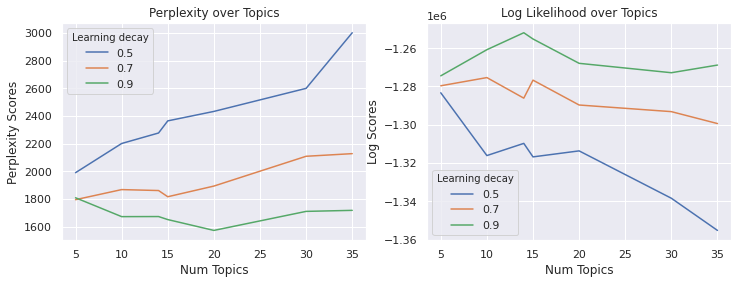

In [ ]:
# Plot the three learning rates on a graph for each number of topics
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(topics, p1, label='0.5')
plt.plot(topics, p2, label='0.7')
plt.plot(topics, p3, label='0.9')
plt.title("Perplexity over Topics")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Scores")
plt.legend(title='Learning decay', loc='best')

plt.subplot(1, 2, 2)
plt.plot(topics, l1, label='0.5')
plt.plot(topics, l2, label='0.7')
plt.plot(topics, l3, label='0.9')
plt.title("Log Likelihood over Topics")
plt.xlabel("Num Topics")
plt.ylabel("Log Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

Analysis:

*  Learning decay of 0.9 appears to be the optimal reaching a minimum perplexity at 20 topics and maximum log-likelihood at 14 topics.













## 8.4 Document and Topic Density

Doc_topic_prior represents document-topic density - higher number means documents are made up of more topics.
Topic_word_prior represents topic-word density - higher number means topics are made up of most of the words 
in the corpus. These are the alpha and beta hyperparameters in the model.

Default = 1/number of components(topics)

In [ ]:
# Function to change density (priors):
def priors(t,p):
  lda4_model = LatentDirichletAllocation(n_components = t,doc_topic_prior = p, topic_word_prior = p,max_iter = 15,
                                        learning_method = "online",learning_decay = 0.9)
  lda4 = lda4_model.fit_transform(vec)
  
  perplex4 = lda4_model.perplexity(vec)
  like4 = lda4_model.score(vec)

  return perplex4,like4
  

In [ ]:
# Priors = 0.1
topics = [5,10,14,15,20,30]
pp1 = []
ll1 = []
for i in topics:
  pp1.append(priors(i,0.1)[0])
  ll1.append(priors(i,0.1)[1])

In [ ]:
# Priors = 0.5
pp2 = []
ll2 = []
for i in topics:
  pp2.append(priors(i,0.5)[0])
  ll2.append(priors(i,0.5)[1])

In [ ]:
# Priors = 0.05
pp3 = []
ll3 = []
for i in topics:
  pp3.append(priors(i,0.05)[0])
  ll3.append(priors(i,0.05)[1])

In [ ]:
# Perplexity dataframe
density = pd.DataFrame([topics,pp1,pp2,pp3]).T
density.columns = (["Topics","0.1","0.5","0.05"])
density

,Topics,0.1,0.5,0.05
0,5.0,1851.149915,1837.299622,1954.530055
1,10.0,1648.797651,1862.663908,1660.384625
2,14.0,1639.008248,2091.129886,1696.971867
3,15.0,1674.384310,2054.614846,1742.138758
4,20.0,1632.237883,2325.618923,1631.625658
5,30.0,1703.971649,2956.721521,1695.061717


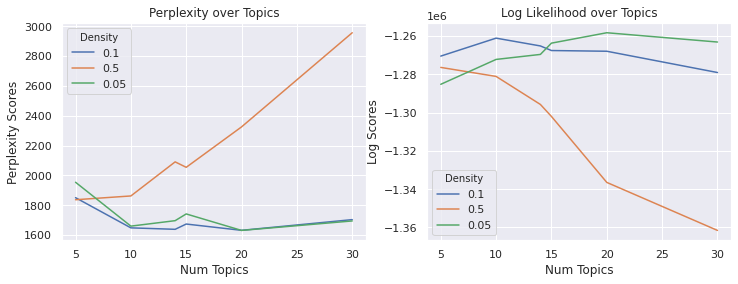

In [ ]:
# Plot the three density values on a graph for each number of topics
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(topics, pp1, label='0.1')
plt.plot(topics, pp2, label='0.5')
plt.plot(topics, pp3, label='0.05')
plt.title("Perplexity over Topics")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Scores")
plt.legend(title='Density', loc='best')

plt.subplot(1, 2, 2)
plt.plot(topics, ll1, label='0.1')
plt.plot(topics, ll2, label='0.5')
plt.plot(topics, ll3, label='0.05')
plt.title("Log Likelihood over Topics")
plt.xlabel("Num Topics")
plt.ylabel("Log Scores")
plt.legend(title='Density', loc='best')
plt.show()

Analysis:


*  14 topics with density = 0.1 returns the lowest perplexity.
* The 0.1 and 0.05 lines are very close but higher density of 0.5 rises sharply as topic numbers increase.
*  Maximum likelihood occurs at 14 topics with 0.1 density but above that the line falls below that for 0.05 density.
* 14 topics at 0.1 density is assumed for the best model.















## 8.5 Change Number of Iterations

In [ ]:
# Increased iterations for 14 topics
def num_iterations(iterations):

  lda5_model = LatentDirichletAllocation(n_components = 14,doc_topic_prior = 0.1, topic_word_prior = 0.1,max_iter = iterations,
                                        learning_method = "online",learning_decay = 0.9)
      
  lda5 = lda5_model.fit_transform(vec)
  perplex5 =lda5_model.perplexity(vec)
  like5 = lda5_model.score(vec)

  return perplex5,like5

In [ ]:
# Increase iterations for 14 topics
iterations = [15,30,50,100]
pi = []
li = []
for i in iterations:
  pi.append(num_iterations(i)[0])
  li.append(num_iterations(i)[1])

In [ ]:
# Perplexity dataframe
iterate = pd.DataFrame([iterations,pi,li]).T
iterate.columns = (["Iterations","Perplexity","Likelihood"])
iterate

,Iterations,Perplexity,Likelihood
0,15.0,1639.063709,-1.262850e+06
1,30.0,1534.626740,-1.258720e+06
2,50.0,1653.232270,-1.250561e+06
3,100.0,1656.677909,-1.250790e+06


Analysis 


*   Doubling the number of iterations appears to improve the model.

# 9.0 Text pre-processing

Pre-processing text can often help to increase the performance of text models so a range of text-processing tasks are run.

In [ ]:
# import libraries
import re
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [ ]:
# Make a copy of the data to perform pre-processing
d1 = data.copy()

In [ ]:
# Create pre-processing function
def process(text):

  # tokenize and remove punctuation
  text = text.text
  tokenizer = RegexpTokenizer(r'\w+')
  text = text.apply(lambda x: tokenizer.tokenize(x.strip().lower()))

  # Remove numbers, except words that contain numbers.
  text = text.apply(lambda x: [n for n in x if not n.isnumeric()])

  # Remove non-ascii characters 
  text = text.apply(lambda x: [e for e in x if e.encode("ascii","ignore")])

  # Remove common/stopwords
  stop = stopwords.words('english')
  add_stop = ['wa','mile','ft','km',"ii","st","mi","born","mp"]
  stop.extend(add_stop)
  text = text.apply(lambda x: [w for w in x if w not in stop])

  # Lemmatize text
  lemmatizer = WordNetLemmatizer()
  def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]
  text = text.apply(lemmatize_text)

  # Stem text - run only to check if improves results
  #stemmer to PorterStemmer()
  #def stem_text(text):
    #return [stemmer.stem(w) for w in text]
  #text = text.apply_stem(text)

  # Convert list to string
  text = text.apply(lambda x: ' '.join(x))

  return text

In [ ]:
process(d1)

245601    waterway experiment station also known wes ori...
252469    ibm building story skyscraper metropolitan tra...
227560    royal enfield fury british motorcycle made roy...
144727    andrés gómez santos february guayaquil ecuador...
196076    kumaree rajeshree deerpalsing january also kno...
                                ...                        
13769     bw offshore previously known bergesen worldwid...
52931     beechworth secondary college state secondary c...
278431    phase also known phase lesbian bar nightclub 8...
61737     horndean technology college large school situa...
476345    woman touch seventeenth studio album singer so...
Name: text, Length: 8000, dtype: object

# 10.0 Fit The Best Model

Bring all the previous tasks together into a function.

In [ ]:
# Create pipeline function for processed text.

# set column names for topics
ind_col = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

def best(x):

  topics = 14

  # Set best model parameters
  best_model = LatentDirichletAllocation(n_components = topics,max_iter = 30, 
                                         doc_topic_prior = 0.1, 
                                         topic_word_prior = 0.1, 
                                         learning_method = "online",batch_size = 100,
                                         learning_decay = 0.9,random_state = 1)
  # pre-process data function
  x = process(x)

  # Convert to numpy array and create vectorizer object 
  d1_array = x.to_numpy()
  vectorizer = CountVectorizer(strip_accents="ascii",max_df = 0.95,min_df = 5,stop_words='english')
  d1_vector = vectorizer.fit_transform(d1_array)

  # Fit model and extract dtm, wtm
  lda_best = best_model.fit_transform(d1_vector)
  word_prob_best = best_model.components_

  # Print perplexity and log score for best model
  print("Perplexity for final model:",best_model.perplexity(d1_vector))
  print("Log score for final model:",best_model.score(d1_vector))

  # Create document topic matrix with top two topics per document
  df_dtm_best = pd.DataFrame(data= lda_best, columns=ind_col)
  df_dtm_best["Top_topic"] = df_dtm_best.idxmax(axis = 1)
  g = df_dtm_best.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
  g.drop([0,1],axis = 1,inplace = True)
  g.columns = ["2nd"]
  df_dtm_best["2nd"] = g["2nd"]
  
  # Create word topic matrix of top ten words for each topic
  feature_names = vectorizer.get_feature_names()
  words = np.array(feature_names)
  top_topics = []
  for topic_weights in word_prob_best:
      word_locs = (-topic_weights).argsort()[:10]
      top_topics.append(words.take(word_locs))
  df_top_words = pd.DataFrame(top_topics,index = ind_col) 
  
  return vectorizer,df_dtm_best, df_top_words, feature_names, best_model


In [ ]:
result = best(d1)

Perplexity for final model: 1345.9075495508048
Log score for final model: -1124435.2395091401


In [ ]:
# Get document topic probabilities
df_dtm_best = result[1]
df_dtm_best.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Top_topic,2nd
0,0.268657,0.002825,0.002825,0.002825,0.002825,0.002825,0.002825,0.002825,0.237736,0.101418,0.079247,0.287516,0.002825,0.002825,12,1
1,0.004673,0.004673,0.004674,0.004673,0.004674,0.004673,0.004673,0.566443,0.377478,0.004673,0.004674,0.004673,0.004673,0.004673,8,9
2,0.006098,0.570592,0.006098,0.006098,0.006098,0.006098,0.006098,0.006100,0.006098,0.006100,0.309534,0.052792,0.006100,0.006098,2,11
3,0.006494,0.006495,0.006495,0.006495,0.073678,0.329221,0.282220,0.006496,0.006494,0.006494,0.006495,0.006494,0.249938,0.006494,6,7
4,0.008772,0.008774,0.008772,0.008773,0.008772,0.885956,0.008773,0.008773,0.008773,0.008772,0.008772,0.008772,0.008773,0.008773,6,2


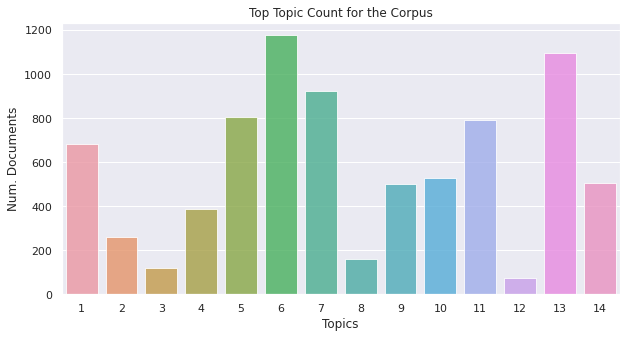

In [ ]:
df_topic_counts = df_dtm_best['Top_topic'].value_counts().reset_index()
df_topic_counts.columns = ['Topic', 'Documents']

# Plot top topic for all documents
plt.figure(figsize=(10,5))
sns.barplot(df_topic_counts["Topic"],df_topic_counts["Documents"],alpha=0.8)
plt.title("Top Topic Count for the Corpus")
plt.ylabel("Num. Documents")
ax = plt.xlabel("Topics")


In [ ]:
# Get word topic matrix - top six words per topic
df_top_words = result[2]
df_top_words

,0,1,2,3,4,5,6,7,8,9
1,school,high,university,college,located,public,student,state,education,secondary
2,genus,family,specie,canadian,known,canada,america,ontario,member,toronto
3,australian,international,australia,summer,citation,world,olympics,needed,competed,airline
4,book,published,novel,series,story,magazine,written,fiction,author,writer
5,album,released,record,band,music,studio,singer,song,rock,label
6,member,played,state,politician,american,october,december,served,football,june
7,film,directed,best,american,starring,star,award,journal,life,based
8,new,york,city,game,known,california,woman,san,people,video
9,historic,church,house,building,located,built,national,place,register,county
10,company,based,founded,group,art,service,museum,largest,united,bank


In [ ]:
# Add inferred guesses based on the word matrix 

Inferred = ["Education","Animal","Athlete","Written","Album","Office Holder",
"Film","Artist","Building","Company","Transport","Natural","Plant","Village"]      
                                                                                             
df_top_words["Inferred"] = Inferred
df_top_words

,0,1,2,3,4,5,6,7,8,9,Inferred
1,school,high,university,college,located,public,student,state,education,secondary,Education
2,genus,family,specie,canadian,known,canada,america,ontario,member,toronto,Animal
3,australian,international,australia,summer,citation,world,olympics,needed,competed,airline,Athlete
4,book,published,novel,series,story,magazine,written,fiction,author,writer,Written
5,album,released,record,band,music,studio,singer,song,rock,label,Album
6,member,played,state,politician,american,october,december,served,football,june,Office Holder
7,film,directed,best,american,starring,star,award,journal,life,based,Film
8,new,york,city,game,known,california,woman,san,people,video,Artist
9,historic,church,house,building,located,built,national,place,register,county,Building
10,company,based,founded,group,art,service,museum,largest,united,bank,Company


Analysis

*   Evaluating unsupervised learning models is not easy since there is no base against which we can test the output of our model. For this dataset however, there is the original labelling.
*   Topics are inferred based on the words in the word-topic matrix but the topics are blury and overlapping highlighting that this is a difficult task.

# 11.0 Prediction

To see how the model performs with predicting on the unseen test data.

## 11.1 A single data point

In [ ]:
# Take sample item from test set and note topic
example = test_data.head(5).sample(1)
example

,label,title,text
2,9,Strzeczonka,Strzeczonka [stʂɛˈt͡ʂɔnka] is a village in th...


In [ ]:
def predict(x):

  # Process text and create dtm
  prep = process(x)
  test_vector = result[0].transform(prep)
  dtm_test = result[4].transform(test_vector)
  df_dtm_test = pd.DataFrame(dtm_test,columns = list(range(1,15)))
  
  # Sort to find top topic for each document
  df_dtm_test["Top"] = df_dtm_test.idxmax(axis = 1)
  h = df_dtm_test.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=3)
  h.drop([0,1],axis = 1,inplace = True)
  h.columns = ["2nd"]
  df_dtm_test["2nd"] = h
  
  top_topic = int(df_dtm_test.iloc[0]["Top"])-1
  second_topic = int(df_dtm_test.iloc[0]["2nd"])-1
  topic_guess = df_top_words.iloc[13]["Inferred"]
  second_guess = df_top_words.iloc[1]["Inferred"]
  
  return topic_guess,second_guess
  

In [ ]:
# Predict sample
predict(example)

('Village', 'Animal')

## 11.2 The Whole Test Set

In [ ]:
# Create df to show original data with actual topic subjects as per the dataset 
dict = {1:"Company",2:"Education",3:"Artist",4:"Athlete",5:"Office Holder",
       6:"Transport",7:"Building",8:"Natural",9:"Village",10:"Animal",
       11:"Plant",12:"Album",13:"Film",14:"Written"}
top = pd.DataFrame(dict.items(),columns = ["label","topic"])

# Join to test data set
test_df = test_data.merge(top, on='label', how='left')
test_df.head(10)

,label,title,text,topic
0,10,Platymetopus,Platymetopus is a genus of beetles in the fam...,Animal
1,10,Sicera,Sicera is a genus of moth in the family Gelec...,Animal
2,9,Strzeczonka,Strzeczonka [stʂɛˈt͡ʂɔnka] is a village in th...,Village
3,7,Rose Hill Manor,Rose Hill Manor is a historic home located at...,Building
4,9,Eslamabad-e Bezahrud,Eslamabad-e Bezahrud (Persian: اسلام اباد بزه...,Village
5,3,Jonathan Singleton,Jonathan Singleton is an American country mus...,Artist
6,5,Hans-Josef Fell,Hans-Josef Fell (born 7 January 1952 in Hamme...,Office Holder
7,5,Darlene Mealy,Darlene Mealy is a member of the New York Cit...,Office Holder
8,1,Air Orient,Air Orient was an airline based in France. Cr...,Company
9,12,Out There (Eric Dolphy album),Out There is a 1960 jazz album by Eric Dolphy...,Album


In [ ]:
# Function to infer topic
def infer(x):

  # Preprocessing function on the test set and convert to dtm
  prep = process(test_data)
  test_vector = result[0].transform(prep)
  whole_test_df = pd.DataFrame(result[4].transform(test_vector),columns = ind_col)
  
  # Create dataframe of top words and themes
  themes = df_top_words["Inferred"]
  themes = themes.reset_index()
  themes.columns = ["Top","Inferred"]

  # Create dataframe of 'inferred topics'
  inferred = pd.DataFrame(whole_test_df.idxmax(axis = 1),columns = ["Top"])
  inferred_2 = whole_test_df.apply(lambda s,n: pd.Series(s.nlargest(n).index), axis=1, n=2)
  inferred_2.drop([0],axis = 1,inplace = True)
  inferred_2.columns = ["Top"]
  inferred_2.index +=1
  
  # Join the two
  Topic_names = inferred.merge(themes, on = 'Top', how = 'left')
  test_df["SKGuess"] = Topic_names["Inferred"]
  Second_topic = inferred_2.merge(themes, on = "Top", how = 'left')
  test_df["SK2ndGuess"] = Second_topic["Inferred"]
   
  return test_df


In [ ]:
test_final = infer(test_data)
test_final.head(15)

,label,title,text,topic,SKGuess,SK2ndGuess
0,10,Platymetopus,Platymetopus is a genus of beetles in the fam...,Animal,Animal,Plant
1,10,Sicera,Sicera is a genus of moth in the family Gelec...,Animal,Animal,Building
2,9,Strzeczonka,Strzeczonka [stʂɛˈt͡ʂɔnka] is a village in th...,Village,Village,Written
3,7,Rose Hill Manor,Rose Hill Manor is a historic home located at...,Building,Building,Office Holder
4,9,Eslamabad-e Bezahrud,Eslamabad-e Bezahrud (Persian: اسلام اباد بزه...,Village,Village,Animal
5,3,Jonathan Singleton,Jonathan Singleton is an American country mus...,Artist,Album,Film
6,5,Hans-Josef Fell,Hans-Josef Fell (born 7 January 1952 in Hamme...,Office Holder,Office Holder,Film
7,5,Darlene Mealy,Darlene Mealy is a member of the New York Cit...,Office Holder,Office Holder,Artist
8,1,Air Orient,Air Orient was an airline based in France. Cr...,Company,Athlete,Company
9,12,Out There (Eric Dolphy album),Out There is a 1960 jazz album by Eric Dolphy...,Album,Album,Office Holder


The model appears to be performing well on the first part of the test data but what is the accuracy across all the 2000 items in the test set?

Based on the top topic for each document:

In [ ]:
# How many are correct guesses based on top topic guess only?
incorrect = test_final[test_final["topic"] != test_final["SKGuess"]].shape[0]
correct = test_final.shape[0]-incorrect
percent_correct = correct/(incorrect+correct)*100
print("Percentage guessed correctly by model:",percent_correct)

Percentage guessed correctly by model: 61.7


Adding in the second guess as well as the first

In [ ]:
# How many are correct guesses based on top topic and second topic guess?
incorrect = test_final[(test_final['topic'] != test_final["SKGuess"]) & (test_final['topic'] != test_final["SK2ndGuess"])].shape[0]
correct = test_final.shape[0]-incorrect
percent_correct = correct/(incorrect+correct)*100
print("Percentage guessed correctly by model:",percent_correct)

Percentage guessed correctly by model: 70.8


Analysis

* The model is correct with 62% of the test_data, not much better than flipping a coin but not too bad considering the complexity of text data and a dataset with several very closely related and overlapping topics. 
* When the second top topic guess is added in, so that the topic can be either of the top one or two topics, then the model returns 71% accuracy.












# 12.0 Gensim - Can we Build a Better Model? 

The next section briefly covers a much more sophisticated and popular library for topic modelling - Gensim. 


## 12.1 Import libraries

In [ ]:
# import libraries
from gensim import corpora,models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import pprint
import warnings
warnings.filterwarnings("ignore")

## 12.2 Create dictionary and corpus

In [ ]:
# Preprocessing function
def pre_proc_gensim(text):

  # Pre-process using previous function
  text_new = process(text)

  # Retokenize text
  tokenizer = RegexpTokenizer(r'\w+')
  text_new = text_new.apply(lambda x: tokenizer.tokenize(x))

  return text_new

## 12.3 Create Bag of Words Model

In [ ]:
# Function to create a unique id for each word in the document. 
def create_corp(text):

  text = pre_proc_gensim(text)

  stop = stopwords.words('english')
  add_stop = ['wa','mile','ft','km',"ii","st","mi","born","mp","hm",
              "e"]
  stop.extend(add_stop)
  text = text.apply(lambda x: [w for w in x if w not in stop])
  
  # Create text with bigrams and unigrams
  bigram = gensim.models.Phrases(text)
  def bigrams_proc(text):
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[w] for w in text]
  text_big = bigrams_proc(text)

  # Create dictionary - allocate each word a unique id
  gen_dict = corpora.Dictionary(text_big)

  # Remove if below 3 occurrences or above 5% of the sample
  gen_dict.filter_extremes(no_below=3, no_above=0.05)

  # Get Term Document Frequency
  bow_corpus = [gen_dict.doc2bow(item) for item in text_big]
  
  return bow_corpus, gen_dict, text_big

In [ ]:
# run create_corp function 
result = create_corp(d1)
bow_corpus = result[0]
gen_dict = result[1]
text_new = result[2]

In [ ]:
# The dictionary shows each word with an id
print(gen_dict.token2id)

{'acre_ha': 0, 'also_known': 1, 'army': 2, 'built': 3, 'campus': 4, 'center': 5, 'complex': 6, 'corp': 7, 'development': 8, 'engineer': 9, 'experiment': 10, 'facility': 11, 'four': 12, 'headquarters': 13, 'laboratory': 14, 'largest': 15, 'listed': 16, 'mississippi': 17, 'original': 18, 'research': 19, 'site': 20, 'station': 21, 'u': 22, 'waterway': 23, 'architect': 24, 'avenue': 25, 'building': 26, 'building_designed': 27, 'city': 28, 'corner': 29, 'fifth': 30, 'metropolitan': 31, 'new_york': 32, 'opposite': 33, 'rainier': 34, 'seattle_washington': 35, 'skyscraper': 36, 'story': 37, 'tower': 38, 'trade': 39, 'world': 40, 'british': 41, 'cc': 42, 'enfield': 43, 'factory': 44, 'fury': 45, 'india': 46, 'made': 47, 'motor': 48, 'motorcycle': 49, 'name': 50, 'new': 51, 'range': 52, 'royal': 53, 'single': 54, 'used': 55, 'andrés': 56, 'best_known': 57, 'ecuador': 58, 'ecuadorian': 59, 'february': 60, 'former_professional': 61, 'french': 62, 'men': 63, 'open': 64, 'santos': 65, 'tennis_player

In [ ]:
# The corpus showing each document is composed of tuples, with the word id and frequency
print(bow_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 2), (9, 4), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1)], [(5, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)], [(41, 1), (42, 2), (43, 3), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 1)], [(54, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(1, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)], [(78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1)], [(95, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (1

In [ ]:
# To find out a word, pass in the id
gen_dict[10]

'experiment'

## 12.4 Building the Base Models with 14 topics

In [ ]:
# Base Gensim model - various parameter combinations tried to get visually 
# coherent topics. Apha and Eta(Beta) are set to 'auto' so the model learns the
# 'priors'.

def mod_func(c,d,t,a,e):

  chunksize = 4000
  passes = 14
  iterations = 50
  
      
  lda_model = gensim.models.ldamodel.LdaModel(corpus=c,id2word=d,iterations = iterations,
                                              alpha = a,eta = e,chunksize = chunksize,passes = passes,
                                              num_topics = t,random_state = 1)
                                                       
  return lda_model

### 12.4.1 Bag of Words Model

In [ ]:
# Base model - Bag of Words
lda_model_1 = mod_func(bow_corpus,gen_dict,14,"auto","auto")

In [ ]:
# Print weighted words
pprint.pprint(lda_model_1.print_topics())

[(0,
  '0.037*"album" + 0.017*"band" + 0.017*"record" + 0.015*"music" + '
  '0.013*"song" + 0.009*"track" + 0.008*"artist" + 0.008*"single" + '
  '0.007*"label" + 0.007*"singer"'),
 (1,
  '0.035*"village" + 0.033*"river" + 0.031*"lake" + 0.021*"district" + '
  '0.019*"county" + 0.015*"mountain" + 0.014*"persian_also" + '
  '0.014*"rural_district" + 0.014*"romanized" + 0.012*"province_iran"'),
 (2,
  '0.041*"film" + 0.019*"directed" + 0.016*"novel" + 0.011*"film_directed" + '
  '0.011*"starring" + 0.009*"series" + 0.008*"written" + 0.007*"story" + '
  '0.007*"star" + 0.007*"book"'),
 (3,
  '0.030*"specie" + 0.015*"family_found" + 0.013*"family_endemic" + '
  '0.012*"specie_plant" + 0.012*"found" + 0.009*"plant" + 0.008*"forest" + '
  '0.008*"white" + 0.007*"loss" + 0.006*"moth"'),
 (4,
  '0.018*"book" + 0.014*"published" + 0.009*"writer" + 0.008*"author" + '
  '0.007*"work" + 0.007*"november" + 0.007*"magazine" + 0.006*"de" + '
  '0.006*"december" + 0.006*"novel"'),
 (5,
  '0.046*"unive

In [ ]:
# Printing out just the words for each topic
for index, topic in lda_model_1.show_topics(num_topics = 14,formatted=False, num_words= 10):
    print(index, [w[0] for w in topic])

0 ['album', 'band', 'record', 'music', 'song', 'track', 'artist', 'single', 'label', 'singer']
1 ['village', 'river', 'lake', 'district', 'county', 'mountain', 'persian_also', 'rural_district', 'romanized', 'province_iran']
2 ['film', 'directed', 'novel', 'film_directed', 'starring', 'series', 'written', 'story', 'star', 'book']
3 ['specie', 'family_found', 'family_endemic', 'specie_plant', 'found', 'plant', 'forest', 'white', 'loss', 'moth']
4 ['book', 'published', 'writer', 'author', 'work', 'november', 'magazine', 'de', 'december', 'novel']
5 ['university', 'college', 'founded', 'art', 'campus', 'student', 'state', 'science', 'education', 'established']
6 ['within', 'genus', 'specie', 'village_administrative', 'district_gmina', 'lie_approximately', 'east', 'north', 'regional_capital', 'village_population']
7 ['class', 'ship', 'navy', 'war', 'us', 'built', 'russian', 'world_war', 'april', 'commissioned']
8 ['house', 'place', 'built', 'register_historic', 'historic', 'building', 'list

In [ ]:
# Get top topic for each document with weight. Note topics have been 
# reindexed from 1.

n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lda_model_1.get_topics()):
    top_ids = topic.argsort()[-n_words:][::-1]
    vals = topic[top_ids]
    words = [gen_dict[id] for id in top_ids]
    topic_df = pd.DataFrame({'topic': i+1,'top_word': words,'weight': vals})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head(12)

,topic,top_word,weight
0,1,album,0.037183
1,1,band,0.017374
2,1,record,0.016796
3,1,music,0.014575
4,1,song,0.012854
5,1,track,0.009103
6,1,artist,0.008485
7,1,single,0.007519
8,1,label,0.006835
9,1,singer,0.006806


In [ ]:
# Determine coherence of this model
print("Log Perplexity:",lda_model_1.log_perplexity(bow_corpus))
coherence_model_lda = CoherenceModel(model=lda_model_1, texts = text_new, dictionary=gen_dict, coherence='c_v')
print("Coherence:",coherence_model_lda.get_coherence())

Log Perplexity: -8.468953041149993
Coherence: 0.49297766247410274


Analysis:
*   Some bigrams have been picked up by the model.
*   The topics still appear fairly mixed and fuzzy
*   Instead of BOW model try the weighted TF-IDF model






### 12.4.2 TFIDF Model

In [ ]:
# Apply tfifg model to bow corpus
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

In [ ]:
# Print example of document with weights
for doc in tfidf_corpus:
    print(doc)
    break

[(0, 0.1454605444538076), (1, 0.07981329025206212), (2, 0.12826945976714887), (3, 0.07171319012323037), (4, 0.10842562567469516), (5, 0.10407572344789856), (6, 0.13249074492367952), (7, 0.4325117597655199), (8, 0.21307507026609535), (9, 0.5504918405855345), (10, 0.176021587726664), (11, 0.24936793107646016), (12, 0.09092551921129206), (13, 0.12582029499920805), (14, 0.1619979332148248), (15, 0.10759808345433272), (16, 0.12205951921681576), (17, 0.14827066026287553), (18, 0.10039793351875376), (19, 0.338158369229249), (20, 0.11238576693177317), (21, 0.12468396553823008), (22, 0.08467629631378451), (23, 0.15322460510133618)]


In [ ]:
# TF-IDF model
lda_model_2 = mod_func(tfidf_corpus,gen_dict,14)

In [ ]:
# Printing out just the words for each topic
for index, topic in lda_model_2.show_topics(num_topics = 14,formatted=False, num_words= 10):
    print(index, [w[0] for w in topic])

0 ['album', 'band', 'record', 'music', 'song', 'artist', 'track', 'singer', 'single', 'label']
1 ['village', 'persian_also', 'rural_district', 'romanized', 'province_iran', 'census_population', 'district', 'high_school', 'central_district', 'county']
2 ['film', 'directed', 'starring', 'film_directed', 'drama_film', 'novel', 'boy', 'movie', 'girl', 'high_school']
3 ['company', 'specie_orchid', 'aircraft', 'built', 'bulbophyllum', 'genus_bulbophyllum', 'service', 'airline', 'air', 'designed']
4 ['specie_beetle', 'hip_hop', 'specie_genus', 'de', 'played', 'drummer', 'mall', 'ukrainian', 'rapper', 'russian']
5 ['river', 'lake', 'university', 'college', 'mountain', 'village_municipality', 'tributary', 'science', 'river_river', 'founded']
6 ['moth_arctiidae', 'family_described', 'puerto_rico', 'graham', 'catfish', 'genus_beetle', 'fly', 'albania', 'family_carabidae', 'american_football']
7 ['gastropod_mollusk', 'specie_sea', 'germany', 'snail_marine', 'novel', 'genus_moth', 'football_player'

In [ ]:
# Print topics weights with top ten words for each
pprint.pprint(lda_model_2.print_topics())

[(0,
  '0.014*"album" + 0.008*"band" + 0.007*"record" + 0.006*"music" + '
  '0.006*"song" + 0.005*"artist" + 0.004*"track" + 0.004*"singer" + '
  '0.004*"single" + 0.004*"label"'),
 (1,
  '0.019*"village" + 0.016*"persian_also" + 0.016*"rural_district" + '
  '0.015*"romanized" + 0.014*"province_iran" + 0.013*"census_population" + '
  '0.011*"district" + 0.011*"high_school" + 0.010*"central_district" + '
  '0.009*"county"'),
 (2,
  '0.014*"film" + 0.009*"directed" + 0.006*"starring" + 0.005*"film_directed" '
  '+ 0.004*"drama_film" + 0.004*"novel" + 0.004*"boy" + 0.004*"movie" + '
  '0.003*"girl" + 0.003*"high_school"'),
 (3,
  '0.007*"company" + 0.006*"specie_orchid" + 0.006*"aircraft" + 0.005*"built" '
  '+ 0.004*"bulbophyllum" + 0.004*"genus_bulbophyllum" + 0.004*"service" + '
  '0.004*"airline" + 0.003*"air" + 0.003*"designed"'),
 (4,
  '0.005*"specie_beetle" + 0.004*"hip_hop" + 0.004*"specie_genus" + 0.004*"de" '
  '+ 0.004*"played" + 0.003*"drummer" + 0.003*"mall" + 0.003*"ukraini

In [ ]:
# Determine perplexity and coherence of this model
print("Log Perplexity:",lda_model_2.log_perplexity(tfidf_corpus))
coherence_model_lda = CoherenceModel(model=lda_model_2, texts = text_new, dictionary=gen_dict, coherence='c_v')
print("Coherence:",coherence_model_lda.get_coherence())

Log Perplexity: -11.070926643340457
Coherence: 0.5056215052525665


Analysis:
* The coherence score is only a little higher and log perplexity is a larger negative suggesting the model is more perplexed by the data. 
* The topic categories seem more fuzzy and harder to interpret for the TF-IDF.



## 12.5 Model Adjustment

### 12.5.1 Optimal Topics

The number of topics will be kept at 14 to enable comparison with the original dataset but it is useful to see what number of topics the the highest coherence score is obtained.

In [ ]:
def model_coherence(c,d):

  topic_num = []
  cv = []
  perplex = []
  for i in range(1,31,2):
    perplexity_score = lda_model_1.log_perplexity(c)
    cv_coherence_model = CoherenceModel(model=mod_func(c,d,i,"auto","auto"), corpus = c,
                                        texts = text_new,dictionary = d,
                                        coherence = 'c_v')
    coherence_score = cv_coherence_model.get_coherence()
    cv.append(coherence_score)
    perplex.append(perplexity_score)
    topic_num.append(i)
 
  return cv,topic_num,perplex


In [ ]:
result_coherence = model_coherence(bow_corpus,gen_dict)
cv = result_coherence[0]
topic_num = result_coherence[1]
perplex = result_coherence[2]

In [ ]:
score_df = pd.DataFrame([topic_num,cv,perplex]).T
score_df.columns = ["Topics","Co_CV","Log Perplexity"]
score_df.set_index("Topics")

,Co_CV,Log Perplexity
Topics,,
1.0,0.405989,-8.469001
3.0,0.353726,-8.469092
5.0,0.349151,-8.469046
7.0,0.403576,-8.469008
9.0,0.503539,-8.469046
11.0,0.500379,-8.469056
13.0,0.495480,-8.469060
15.0,0.501837,-8.469047
17.0,0.479117,-8.469093


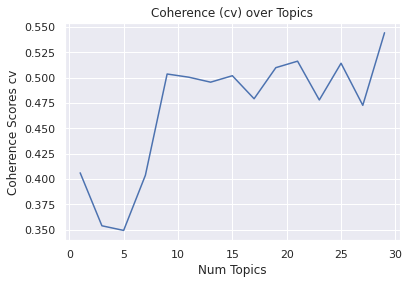

In [ ]:
# Plot Coherence Scores Against Number of Topics
plt.plot(topic_num, cv, label='Co_cv')
plt.title("Coherence (cv) over Topics")
plt.xlabel("Num Topics")
ax = plt.ylabel("Coherence Scores cv")

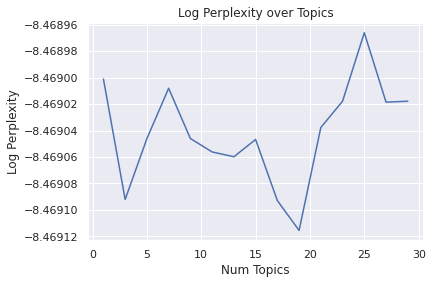

In [ ]:
# Plot Perplexity Scores Against Number of Topics
plt.plot(topic_num, perplex, label='Perplex')
plt.title("Log Perplexity over Topics")
plt.xlabel("Num Topics")
ax = plt.ylabel("Log Perplexity")

* Coherence rises sharply up to 9 topics and then appears to plateau up to 15.
* There are several places where the coherence peaks at 21 and 29 topics.
* Log perplexity has the lowest negative value at around 25 topics.

### 12.5.2 Alpha and Beta

These are determined by the model but they can be tuned as hyperparameters. To find the highest Coherence Score ranges of Alpha and Beta are passed to the LDA model and to the Coherence model. Sorting and extracting them to find the highest CV score.

In [ ]:
# Run values of alpha and beta through the model
cv = []
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

for i in alpha:
  for j in beta:
    lda_model_3 = mod_func(bow_corpus,gen_dict,14,i,j)
    coherence_model = CoherenceModel(model=lda_model_3, corpus =bow_corpus,
                                     texts = text_new,dictionary=gen_dict,coherence='c_v')
    coherence = coherence_model.get_coherence()                          
    cv.append(coherence)

In [ ]:
# Create dataframe 
alpha_list = [0.01,0.01,0.01,0.01,0.01,0.31,0.31,0.31,0.31,0.31,0.61,0.61,0.61,0.61,0.61, 0.91,0.91,0.91,0.91,0.91,
              'symmetric','symmetric','symmetric','symmetric','symmetric','asymmetric','asymmetric','asymmetric','asymmetric','asymmetric']
beta_list = [0.01, 0.31, 0.61, 0.91, 'symmetric',0.01, 0.31, 0.61, 0.91, 'symmetric',0.01, 0.31, 0.61, 0.91, 
             'symmetric',0.01, 0.31, 0.61, 0.91, 'symmetric',0.01, 0.31, 0.61, 0.91, 
             'symmetric',0.01, 0.31, 0.61, 0.91, 'symmetric']
tc = pd.DataFrame([beta_list,alpha_list]).T
tc.columns = ["Alpha","Beta"]
tc["CV"] = cv
tc.sort_values(by = "CV",ascending = False).head()      

,Alpha,Beta,CV
23,0.91,symmetric,0.569680
3,0.91,0.01,0.567348
18,0.91,0.91,0.554898
2,0.61,0.01,0.547306
28,0.91,asymmetric,0.542565


Analysis:
* A value of 0.91 for Alpha and "symmetric" for Beta returns the highest score so this is used to run the best model.

# 12.6 Best Model

In [ ]:
lda_model_4 = mod_func(bow_corpus,gen_dict,14,0.91,"symmetric")
#pprint.pprint(lda_model_1.print_topics())


In [ ]:
for index, topic in lda_model_4.show_topics(num_topics = 14,formatted=False, num_words= 10):
    print(index, [w[0] for w in topic])

0 ['album', 'record', 'band', 'music', 'song', 'single', 'track', 'artist', 'singer', 'release']
1 ['river', 'village', 'lake', 'district', 'county', 'mountain', 'north', 'persian_also', 'rural_district', 'romanized']
2 ['film', 'novel', 'directed', 'series', 'film_directed', 'starring', 'written', 'star', 'story', 'british']
3 ['specie', 'genus', 'western', 'found', 'mexico', 'australia', 'described', 'including', 'white', 'specie_genus']
4 ['book', 'published', 'work', 'de', 'author', 'november', 'writer', 'september', 'career', 'canadian']
5 ['university', 'college', 'established', 'student', 'founded', 'campus', 'education', 'science', 'state', 'academy']
6 ['russian', 'game', 'team', 'played', 'league', 'family_endemic', 'may', 'specie_plant', 'australian', 'family_found']
7 ['class', 'war', 'ship', 'navy', 'built', 'us', 'world_war', 'german', 'car', 'commissioned']
8 ['house', 'served', 'former', 'march', 'january', 'november', 'state', 'home', 'john', 'house_representative']
9 

In [ ]:
print("Log Perplexity:",lda_model_4.log_perplexity(bow_corpus))

Log Perplexity: -8.495352612664552


## 12.6 Visualisation of the Model

In [ ]:
# Note the topics generated here do not match to the topic numbers in the 
# original model
pyLDAvis.enable_notebook()
import pyLDAvis.gensim
lda_vis = pyLDAvis.gensim.prepare(lda_model_4, bow_corpus, gen_dict,sort_topics = False)
pyLDAvis.display(lda_vis)  

The chart shows the topics are overlapping with many of the top words falling into more than one topic. This illustrates the lack of clarity with the model.

## 12.7 Prediction

### One Sample Document

In [ ]:
# Get the topics and top words from the model for reference
for index, topic in lda_model_4.show_topics(num_topics = 14,formatted=False, num_words= 10):
    print(index, [w[0] for w in topic])

0 ['album', 'record', 'band', 'music', 'song', 'single', 'track', 'artist', 'singer', 'release']
1 ['river', 'village', 'lake', 'district', 'county', 'mountain', 'north', 'persian_also', 'rural_district', 'romanized']
2 ['film', 'novel', 'directed', 'series', 'film_directed', 'starring', 'written', 'star', 'story', 'british']
3 ['specie', 'genus', 'western', 'found', 'mexico', 'australia', 'described', 'including', 'white', 'specie_genus']
4 ['book', 'published', 'work', 'de', 'author', 'november', 'writer', 'september', 'career', 'canadian']
5 ['university', 'college', 'established', 'student', 'founded', 'campus', 'education', 'science', 'state', 'academy']
6 ['russian', 'game', 'team', 'played', 'league', 'family_endemic', 'may', 'specie_plant', 'australian', 'family_found']
7 ['class', 'war', 'ship', 'navy', 'built', 'us', 'world_war', 'german', 'car', 'commissioned']
8 ['house', 'served', 'former', 'march', 'january', 'november', 'state', 'home', 'john', 'house_representative']
9 

In [ ]:
# Take the first item from the test set - the topic is "Plant"
test_data.iloc[100]

label                                                   11
title                                              Argusia
text      Argusia is a genus of plant in family Boragin...
Name: 100, dtype: object

In [ ]:
# Convert test text to BOW and run through the model
test_text = pre_proc_gensim(test_data)
test_bow = [gen_dict.doc2bow(item) for item in test_text]
lda_model_4.get_document_topics(test_bow[100])

[(0, 0.050339065),
 (1, 0.040024005),
 (2, 0.04534676),
 (3, 0.07752017),
 (4, 0.046436664),
 (5, 0.04020268),
 (6, 0.13134262),
 (7, 0.09560138),
 (8, 0.0773502),
 (9, 0.04571443),
 (10, 0.051953193),
 (11, 0.20083372),
 (12, 0.051949613),
 (13, 0.045385525)]

The topics 6 and 11 have the highest weight and taken together seems to relate to plants.

### Whole Test Set

In [ ]:
# Get top topic and weights for all documents in the test set
# Set index to start from 1 not zero.

answer = []
for item in test_bow:
    top_res = lda_model_4.get_document_topics(item)
    top = max(top_res,key = lambda item:item[1])
    answer.append(top)
tester = pd.DataFrame(answer,columns = ["Top_topic","Weight"])
tester["Top_topic"] = tester["Top_topic"]+1
tester.head() 

,Top_topic,Weight
0,4,0.140126
1,12,0.171109
2,2,0.376334
3,9,0.403099
4,2,0.424891


In [ ]:
# Create a dataframe of each topic and the top three words associated with it
top_3 = []
for index, topic in lda_model_4.show_topics(num_topics = 14,formatted=False, num_words= 3):
  top = [w[0] for w in topic]
  top = " ".join(top)
  top_3.append(top)
s = pd.Series(top_3)

In [ ]:
df = pd.DataFrame(s,columns = ["Top_3_words"])
df.reset_index(inplace = True)
df.columns = ["Top_topic","Gen_top_3"]
df.Top_topic+=1
df.head(14)

,Top_topic,Gen_top_3
0,1,album record band
1,2,river village lake
2,3,film novel directed
3,4,specie genus western
4,5,book published work
5,6,university college established
6,7,russian game team
7,8,class war ship
8,9,house served former
9,10,built place magazine


In [ ]:
# Merge the dataframes so we have the topic and top 2
# words for each document
gen_sum = tester.merge(df, how = "left",on = "Top_topic")
gen_sum.drop(["Weight"],axis = 1,inplace = True)

In [ ]:
# Add the gensim data to the original test result dataframe
test_final_2 = test_final.join(gen_sum)
test_final_2.head(20)

,label,title,text,topic,SKGuess,SK2ndGuess,Top_topic,Gen_top_3
0,10,Platymetopus,Platymetopus is a genus of beetles in the fam...,Animal,Animal,Plant,4,specie genus western
1,10,Sicera,Sicera is a genus of moth in the family Gelec...,Animal,Animal,Building,12,within specie plant
2,9,Strzeczonka,Strzeczonka [stʂɛˈt͡ʂɔnka] is a village in th...,Village,Village,Written,2,river village lake
3,7,Rose Hill Manor,Rose Hill Manor is a historic home located at...,Building,Building,Office Holder,9,house served former
4,9,Eslamabad-e Bezahrud,Eslamabad-e Bezahrud (Persian: اسلام اباد بزه...,Village,Village,Animal,2,river village lake
5,3,Jonathan Singleton,Jonathan Singleton is an American country mus...,Artist,Album,Film,1,album record band
6,5,Hans-Josef Fell,Hans-Josef Fell (born 7 January 1952 in Hamme...,Office Holder,Office Holder,Film,14,member december party
7,5,Darlene Mealy,Darlene Mealy is a member of the New York Cit...,Office Holder,Office Holder,Artist,11,high_school church part
8,1,Air Orient,Air Orient was an airline based in France. Cr...,Company,Athlete,Company,13,company based group
9,12,Out There (Eric Dolphy album),Out There is a 1960 jazz album by Eric Dolphy...,Album,Album,Office Holder,1,album record band


Analysis:
*   The Gensim model peforms quite well on the topics even when coerced to 14 topics and with considerable topic fuzziness across some of the topic categories such as Plant/Animal/Nature and Company/Transport. 
* Some of the topics like Athlete and Artist can't really be identified at all.
* Looking at the topic distributions one by one for a given sample document and not just inferring the topic from the one highest weighted word, seems to produce best results for this model. This reflects the evenly spread weights for topics across documents.
* Because we are not inferring one single topic, it is not possible to calculate the accuracy to compare with the Scikit Learn model.
* Further work might include pre-processing to select just nouns, adjusting the hyperparameters further and using a much larger dataset to train the data, since 8000 documents is actually quite small for a text model, given that the text per document is also quite low at 46 words on average.



